In [1]:
import datetime
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_fmt_float("full")

polars.config.Config

In [2]:
txs = pl.scan_parquet('transactions/*.parquet')
blocks = pl.scan_parquet('blocks/*.parquet')
mempool = pl.scan_parquet('data/transaction-data/*.parquet')

In [3]:
txs_blocks = (
    txs.join(blocks, on='block_number', how='left', suffix='_block').join(mempool.select('hash', 'timestamp'), right_on='hash', left_on='transaction_hash', how='left', suffix='_mempool')
    .with_columns([
        (pl.col('gas_used') * pl.col('gas_price') / 10**18).alias('tx_gas_cost'),
        pl.from_epoch('timestamp').alias('block_datetime'),
        pl.col('transaction_index').max().over(pl.col("block_number")).name.suffix("_max"),
        (pl.col('gas_price') / pl.col('base_fee_per_gas')).alias('block_gas_premium'),  # premium of the gas price over the base block gas fee
    ])
    .with_columns((pl.col('transaction_index') / pl.col('transaction_index_max') * 100).alias('blockspace_percentile'))
    .with_columns((pl.col("blockspace_percentile").round()).alias("rounded_blockspace_percentile")).fill_nan(0)
    .filter(pl.col('from_address') == '0xc1b634853cb333d3ad8663715b08f41a3aec47cc'.lower()).unique() # Arbitrum: Batch Submitter
    .collect(streaming=True))

In [4]:
ordinals_spam_filter = txs_blocks.filter(pl.col('block_datetime') > datetime.datetime(2023,12,15)).filter(pl.col('block_datetime') < datetime.datetime(2023,12,16))

In [5]:
ordinals_spam_filter.select('block_datetime', 'timestamp_mempool').with_columns([
    (pl.col('block_datetime') - pl.col('timestamp_mempool')).alias('block_mempool_time_diff')]).sort(by='block_mempool_time_diff', descending=True)

block_datetime,timestamp_mempool,block_mempool_time_diff
datetime[μs],datetime[ms],duration[ms]
2023-12-15 18:11:11,2023-12-15 17:45:44.876,25m 26s 124ms
2023-12-15 18:11:11,2023-12-15 17:45:45.749,25m 25s 251ms
2023-12-15 21:47:59,2023-12-15 21:37:08.884,10m 50s 116ms
2023-12-15 21:47:59,2023-12-15 21:37:08.989,10m 50s 11ms
2023-12-15 21:47:47,2023-12-15 21:37:07.379,10m 39s 621ms
2023-12-15 17:54:23,2023-12-15 17:45:50.663,8m 32s 337ms
2023-12-15 13:08:47,2023-12-15 13:00:17.821,8m 29s 179ms
2023-12-15 13:08:47,2023-12-15 13:00:18.324,8m 28s 676ms
2023-12-15 14:12:11,2023-12-15 14:03:49.972,8m 21s 28ms


<Axes: title={'center': 'Time between mempool and block inclusion (Arbitrum)'}, ylabel='Frequency'>

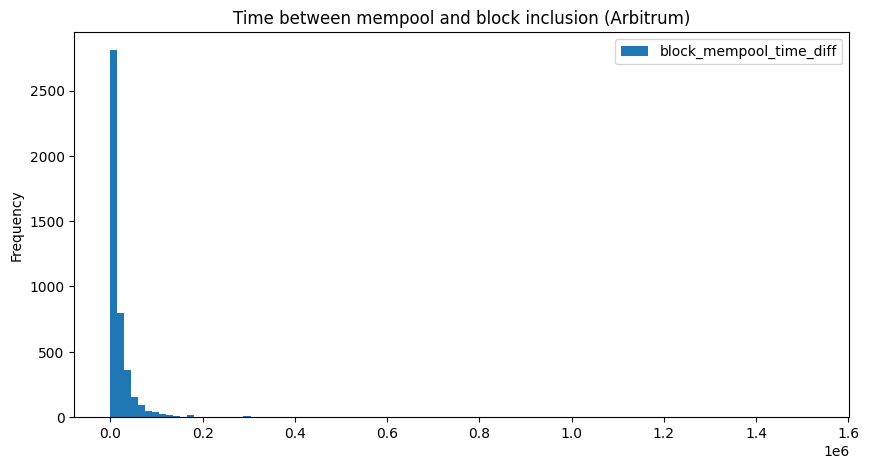

In [6]:
ordinals_spam_filter.select('block_datetime', 'timestamp_mempool').with_columns([
    (pl.col('block_datetime') - pl.col('timestamp_mempool')).alias('block_mempool_time_diff').cast(pl.Float64),
]).to_pandas().plot(kind='hist', bins=100, figsize=(10,5), title='Time between mempool and block inclusion (Arbitrum)')

In [7]:
ordinals_spam_filter.filter(pl.col('block_number') ==18794444).shape

(9, 31)

In [8]:
ordinal_spam_stats_df = ordinals_spam_filter.group_by('block_number').agg(
    pl.col('block_datetime').first().alias('datetime'),
    (pl.col('base_fee_per_gas').first() / 10**9).alias('base_fee_per_gas_gwei'),
    pl.col('gas_used_block').first().alias('block_gas_used'),
    pl.col('gas_used').sum().alias('sequencer_gas_used_sum'),
    pl.col('transaction_index_max').first().alias('block_tx_size'),
    pl.count().alias('sequencer_tx_count')
    ).with_columns(
        (pl.col('sequencer_gas_used_sum') / pl.col('block_gas_used')).alias('seq_gas_block_percent'),
        (pl.col('sequencer_tx_count') / pl.col('block_tx_size')).alias('seq_tx_block_percent')
        ).sort(by='datetime', descending=True)

In [9]:
ordinal_spam_stats_df.sort(by='sequencer_gas_used_sum', descending=True)

block_number,datetime,base_fee_per_gas_gwei,block_gas_used,sequencer_gas_used_sum,block_tx_size,sequencer_tx_count,seq_gas_block_percent,seq_tx_block_percent
u32,datetime[μs],f64,u64,u64,u64,u32,f64,f64
18793076,2023-12-15 17:43:35,134.288994722,29997674,26999957,77,15,0.9000683519662225,0.19480519480519481
18793062,2023-12-15 17:40:47,139.118959901,29962775,26703504,57,15,0.8912226587824392,0.2631578947368421
18793071,2023-12-15 17:42:35,139.340984898,29992475,26693117,76,15,0.8899938067798673,0.19736842105263158
18793028,2023-12-15 17:33:59,139.996236846,29971640,26664650,48,15,0.8896626944671696,0.3125
18792742,2023-12-15 16:35:47,140.206382474,28971428,26618682,61,15,0.9187908169386749,0.2459016393442623
18792697,2023-12-15 16:26:47,139.008033837,29973029,26531917,59,15,0.8851930513929707,0.2542372881355932
18794375,2023-12-15 22:05:59,134.730453865,29967332,26505729,53,15,0.884487447864895,0.2830188679245283
18792722,2023-12-15 16:31:47,140.410596372,29974089,26488855,76,15,0.883725106707997,0.19736842105263158
18792685,2023-12-15 16:24:23,137.01669267,29991882,26466346,61,15,0.8824503243911136,0.2459016393442623


In [10]:
# filter ordinal_spam_stats_df for datetime between 2023-12-15 15:29 and 2023-12-15 16:57 

ordinal_spam_stats_df.filter(pl.col('datetime') > datetime.datetime(2023,12,15,15,29)).filter(pl.col('datetime') < datetime.datetime(2023,12,15,16,57)).sort(by='sequencer_gas_used_sum', descending=True).sort(by='block_number')

block_number,datetime,base_fee_per_gas_gwei,block_gas_used,sequencer_gas_used_sum,block_tx_size,sequencer_tx_count,seq_gas_block_percent,seq_tx_block_percent
u32,datetime[μs],f64,u64,u64,u64,u32,f64,f64
18792413,2023-12-15 15:29:11,119.768635407,20863097,10529448,195,6,0.50469247207162,0.03076923076923077
18792414,2023-12-15 15:29:23,125.620428131,18071352,8651717,90,5,0.478753166890889,0.05555555555555555
18792415,2023-12-15 15:29:35,128.83563274,14604953,5291864,142,3,0.3623335179510677,0.02112676056338028
18792417,2023-12-15 15:29:59,118.97374437,11895868,1740539,141,1,0.14631458587132945,0.0070921985815602835
18792425,2023-12-15 15:31:35,95.726746751,15079670,1738687,159,1,0.11530006956385651,0.006289308176100629
18792427,2023-12-15 15:31:59,92.646971332,24091036,12281412,144,7,0.5097917748327635,0.04861111111111111
18792428,2023-12-15 15:32:11,99.665779262,22138569,10402005,163,6,0.46985895971867014,0.03680981595092025
18792429,2023-12-15 15:32:23,105.594704613,20936253,10708211,136,6,0.5114674053661846,0.04411764705882353
18792430,2023-12-15 15:32:35,110.818345296,17477974,10544592,125,6,0.6033074542850333,0.048


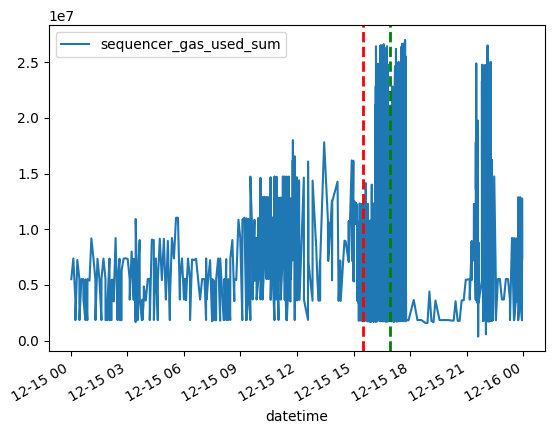

In [11]:
ordinal_spam_stats_df.to_pandas().plot(kind='line', x='datetime', y='sequencer_gas_used_sum')

# Adding vertical lines at 3:29 PM and 4:57 PM UTC
plt.axvline(pd.Timestamp('2023-12-15 15:29'), color='r', linestyle='--', lw=2, label='3:29 PM UTC')
plt.axvline(pd.Timestamp('2023-12-15 16:57'), color='g', linestyle='--', lw=2, label='4:57 PM UTC')


On Ethereum, a block's max gas limit was changed from 15m to 30m as a [result of EIP-1559](https://decentralizedthoughts.github.io/2022-03-10-eip1559/). EIP-1559 targetes a 15m limt. With EIP-1559, the base fee will increase and decrease by up to 12.5% after blocks are more than 50% full. For example, if a block is 100% full the base fee increases by 12.5%; if it is 50% full the base fee will be the same; if it is 0% full the base fee would decrease by 12.5% [(source, consensys)](https://consensys.io/blog/what-is-eip-1559-how-will-it-change-ethereum). 

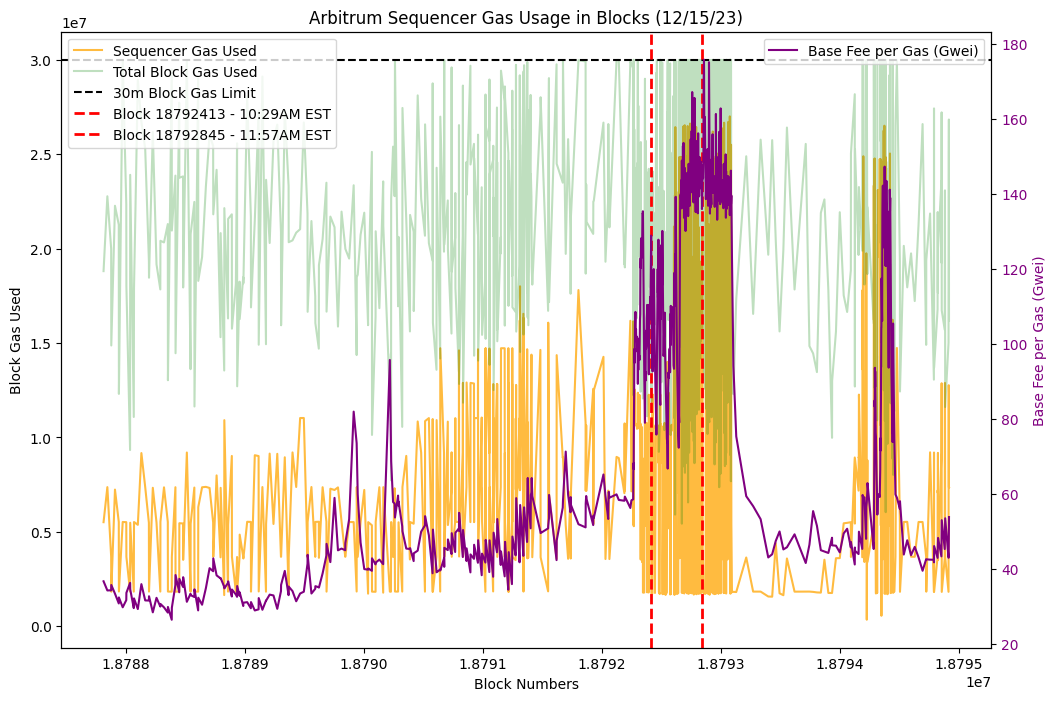

In [12]:
# Convert to pandas DataFrame (if not already)
plot_df = ordinal_spam_stats_df.to_pandas()

# Create a single plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot 'sequencer_gas_used_sum' and 'block_gas_used' on the first y-axis
ax1.plot(plot_df['block_number'], plot_df['sequencer_gas_used_sum'], label='Sequencer Gas Used', color='orange', alpha=0.75)
ax1.plot(plot_df['block_number'], plot_df['block_gas_used'], label='Total Block Gas Used', color='green', alpha=0.25)
ax1.axhline(y=3e7, color='black', linestyle='--', label='30m Block Gas Limit')
ax1.set_xlabel('Block Numbers')
ax1.set_ylabel('Block Gas Used', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# vertical lines where arbitrum sequencer was offline
ax1.axvline(x=18792413, color='red', linestyle='--', lw=2, label='Block 18792413 - 10:29AM EST')
ax1.axvline(x=18792845, color='red', linestyle='--', lw=2, label='Block 18792845 - 11:57AM EST')
ax1.legend(loc='upper left')

# Create a twin y-axis for 'base_fee_per_gas_gwei'
ax2 = ax1.twinx()
ax2.plot(plot_df['block_number'], plot_df['base_fee_per_gas_gwei'], label='Base Fee per Gas (Gwei)', color='purple')
ax2.set_ylabel('Base Fee per Gas (Gwei)', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.legend(loc='upper right')




# Title
plt.title('Arbitrum Sequencer Gas Usage in Blocks (12/15/23)')

# Show the plot
plt.show()